<a href="https://colab.research.google.com/github/Buy-me-some-str/practice/blob/main/Py_torch_02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

### Классификация Pytorch

In [3]:
#1.import data
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [5]:
print("X:",X[:5], "y:",y[:5])

X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] y: [1 1 1 1 0]


In [6]:
circles = pd.DataFrame({"X1":X[:, 0], 
                        "X2":X[:, 1],
                        "label": y})

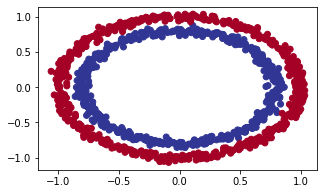

In [7]:
plt.figure(figsize=(5, 3))
plt.scatter(x=circles.X1,
            y=circles.X2,
            c=circles.label,
            cmap=plt.cm.RdYlBu)

In [8]:
#1.1 размерности
X.shape, y.shape
X.dtype

dtype('float64')

In [9]:
#1.2 тензоры
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
#1.3 разбиение
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,
                                                    random_state = 42)

In [11]:
len(X_train), len(y_test)

(800, 200)

In [12]:
#2 построение модели
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=5)
        self.layer_2 = nn.Linear(in_features=5,
                                 out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [14]:
model_0 = CircleModelV0()
model_0 = model_0.to(device)

In [15]:
model_0.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.6572,  0.3412],
                      [-0.4538,  0.5638],
                      [ 0.1809,  0.0467],
                      [ 0.6653,  0.5977],
                      [-0.5059, -0.3329]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5858, -0.0175,  0.3021,  0.2048, -0.3392], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.4453, -0.2279,  0.3171, -0.3802, -0.1166]], device='cuda:0')),
             ('layer_2.bias', tensor([0.0777], device='cuda:0'))])

In [43]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, 
              out_features=15),
    nn.Linear(in_features=15, 
              out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): Linear(in_features=15, out_features=1, bias=True)
)

In [44]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    print(untrained_preds[:5].squeeze(dim=1), y_test[:5])

tensor([ 0.1266, -0.0089,  0.0427,  0.1522, -0.6542], device='cuda:0') tensor([1., 0., 1., 0., 1.], device='cuda:0')


In [45]:
#2.1 функция потерь (с автоматической сигмоидной активацией)
loss_fn = torch.nn.BCEWithLogitsLoss()
##nn.BCEWithLogitLoss() = nn.Sequential(
##      nn.Sigmoid(),
##      nn.BCELoss()
##)
#2.2 оптимизатор (SGD, Adam)
optim = torch.optim.SGD(params=model_0.parameters(),
                         lr=0.01)
#оптимизатор оптимизирует параметры из model_0.parameters()
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6386, -0.6007,  0.5459,  0.1177, -0.2296,  0.4370,  0.1102,  0.5713,
                       0.0773, -0.2230,  0.1900, -0.1918,  0.2976,  0.6313,  0.4087],
                     device='cuda:0')),
             ('1.weight',
              tensor([[-0.1129,  0.1490,  0.0462,  0.1311, -0.1574, 

In [46]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    #item() - из тензора делает число
    accuracy = (correct/len(y_pred))*100
    return accuracy
untrained_preds_probs = torch.sigmoid(untrained_preds.cpu())
accuracy_fn(y_train.cpu(), torch.round(untrained_preds_probs.cpu()))

40000.0

In [47]:
#logits_>pred_prob->label

In [48]:
#3.Тренировочный цикл
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
loss_value = []
test_loss_value = []
count_epochs = []

In [49]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [50]:
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0.forward(X_train).squeeze() #-1 измерение
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train,
                           y_pred=y_pred)
    optim.zero_grad()
    loss.backward()
    optim.step()
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,
                            y_test)
        test_accuracy = accuracy_fn(y_true=y_test,
                                  y_pred=test_pred)
    if epoch%10==0:
        count_epochs.append(epoch)
        loss_value.append(accuracy)
        test_loss_value.append(test_accuracy)

In [51]:
with torch.inference_mode():
    test_pred_logits = model_0.forward(X_test).squeeze()

In [52]:
test_pred_probs = torch.sigmoid(test_pred_logits)
test_pred = torch.round(test_pred_probs)
X_test = X_test.to('cpu')
test_pred = test_pred.to('cpu')

In [53]:
X_test.device, test_pred.device

(device(type='cpu'), device(type='cpu'))

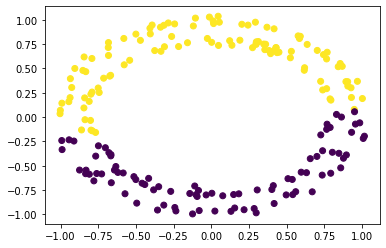

In [54]:
plt.scatter(X_test[:,0], 
            X_test[:,1], 
            c = test_pred)